# Circuit construction

This page takes a closer look at Qiskit's `QuantumCircuit` class, including some more advanced methods you can use to create quantum circuits.

## The `QuantumCircuit` class

The simplest quantum circuit is a collection of qubits, and a list of instructions that act on those qubits. For example, the following cell creates a new circuit with two new qubits, then displays the circuit's `qubits` attribute.

In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.qubits

[Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)]

When we add an instruction to the circuit, this appends the instruction to the circuit's `data` attribute. The following cell output shows `data` is a list of `CircuitInstruction` objects, each of which has an `operation` attribute, and `qubits` attribute.

In [2]:
qc.x(0)
qc.data

[CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=())]

(TODO: make clearer) Circuit instructions can have a definition circuit, but this isn't required; there must be some fundamental instructions that can't be broken down any more. For example, the X-gate in the circuit defined earlier is defined as a U3-gate with specific angles (TODO).

Circuit instructions can be defined in terms of other circuits, but some

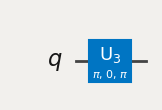

In [3]:
# Get definition of 0th instruction in `qc`
x_definition = qc.data[0].operation.definition
x_definition.draw('mpl')

The rest of this page will show you how to manipulate these quantum circuits.

## Building circuits

TODO: explain gates vs circuits

You've probably already seen methods such as `.h` and `.cx` that add gates to circuits. To add gates to a circuit more generally, use the `append` method. This takes an instruction, plus a list of qubits to apply the instruction to. See the [Circuit Library API documentation]() for a list of supported instructions.

In [4]:
from qiskit.circuit.library import HGate

qc = QuantumCircuit(1)
qc.append(
    HGate(),  # new HGate object
    [0]       # apply to qubit 0
)
qc.draw()

┌───┐
q: ┤ H ├
   └───┘

To combine two circuits, use the `compose` method. This accepts another `QuantumCircuit`, and an optional list of qubit mappings.

> **Note:** The `compose` method returns a new circuit and does **not** mutate either circuit it acts on. If you want to mutate, use the argument `inplace=True` to mutate the circuit you call `compose` from.

In [5]:
qc_a = QuantumCircuit(4)
qc_a.x(0)

qc_b = QuantumCircuit(2, name="qc_b")
qc_b.y(0)
qc_b.z(1)

# compose qubits (0, 1) of qc_a to qubits (1, 3) of qc_b respectively
combined = qc_a.compose(qc_b, qubits=[1, 3])
combined.draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ Y ├
     └───┘
q_2: ─────
     ┌───┐
q_3: ┤ Z ├
     └───┘

You may also want to compile circuits into instructions to keep your circuits organized. You can convert a circuit to an instruction using the `to_instruction` method, then append this to another circuit as you would any other instruction.

In [6]:
inst = qc_b.to_instruction()
qc_a.append(inst, [1, 3])
qc_a.draw()

┌───┐  
q_0: ──┤ X ├──
     ┌─┴───┴─┐
q_1: ┤0      ├
     │       │
q_2: ┤  qc_b ├
     │       │
q_3: ┤1      ├
     └───────┘

If your circuit is unitary, then you can convert it to a `Gate` using the `to_gate` method. `Gate` objects are more specific types of instructions that have some extra features, such as the `control` method which add a quantum control.

TODO: link to API reference

In [7]:
gate = qc_b.to_gate().control()
qc_a.append(gate, [0, 1, 3])
qc_a.draw()

┌───┐           
q_0: ──┤ X ├──────■────
     ┌─┴───┴─┐┌───┴───┐
q_1: ┤0      ├┤0      ├
     │       ││       │
q_2: ┤  qc_b ├┤  qc_b ├
     │       ││       │
q_3: ┤1      ├┤1      ├
     └───────┘└───────┘

To see what's going on, you can use the `decompose` method to expand each instruction using their definitions.

> **Note:** The `decompose` method returns a new circuit and does **not** mutate the circuit it acts on.

In [8]:
qc_a.decompose().draw()

┌───────────┐                            
q_0: ┤ U3(π,0,π) ├────────■───────────■───────
     └───┬───┬───┘┌───────┴────────┐  │       
q_1: ────┤ Y ├────┤ U(π,π/2,π/2,0) ├──┼───────
         └───┘    └────────────────┘  │       
q_2: ─────────────────────────────────┼───────
         ┌───┐          ┌───┐       ┌─┴─┐┌───┐
q_3: ────┤ Z ├──────────┤ H ├───────┤ X ├┤ H ├
         └───┘          └───┘       └───┘└───┘

## Parameterized circuits

Most near-term quantum algorithms run many variations of quantum circuits, tweaking gate parameters to find circuits that create states with certain properties. For these algorithms, you can create circuits with undetermined `Parameter`s that you can assign values to immediately before running the circuit. The following cell creates a circuit with one RX-gate, which rotates its qubit by an undetermined angle.

In [9]:
from qiskit.circuit import Parameter

angle = Parameter("angle")  # undetermined number

qc = QuantumCircuit(1)
qc.rx(angle, 0)
qc.draw()

┌───────────┐
q: ┤ Rx(angle) ├
   └───────────┘

Parameterized circuits help shorten the loop between running circuits and evaluating their results.

In [11]:
qc.bind_parameters({ angle: 0 }).draw()

┌───────┐
q: ┤ Rx(0) ├
   └───────┘

In [12]:
qc.parameters

ParameterView([Parameter(angle)])